# 0. Set up

In [1]:
!nvidia-smi

Wed Dec 15 16:33:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Quadro R...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   28C    P8    14W / 250W |      0MiB / 45556MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Imports

In [2]:
#import 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import rawpy
from tqdm import tqdm as pbar
import copy
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
import seaborn
import cv2
seaborn.set()
import scipy
import albumentations as A
import cv2
import numpy as np
from PIL import Image

In [3]:
data_path = 'dataset'
train_path = '/Sony_train_list.txt'
test_path = '/Sony_test_list.txt'
val_path = '/Sony_val_list.txt'
# np.random.seed(0)
# torch.manual_seed(0)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

# 1. Preprocess raw data from camera sensor

![](figures/3a.png)

Pack raw Bayer sensor data into 4 channels (R-G-B-G). By doing this also reduces resolution by factor of 2

## 1.1 Pack raw is used for input 

In [4]:
def pack_raw(raw):
    """
    Input: object returned from rawpy.imread()
    Output: numpy array in shape (1424, 2128, 4)
    """
    
    im = raw.raw_image_visible.astype(np.float32) # shape of (2848, 4256)
    im = np.maximum(im - 512, 0) / (16383 - 512) #subtract the black level
    im = np.expand_dims(im, axis=2) # shape of (2848, 4256, 1)

    img_shape = im.shape # (H, W, 1)
    H = img_shape[0]
    W = img_shape[1]
    
    # Pack into 4 channels
    red = im[0:H:2,0:W:2,:]
    green_1 = im[0:H:2,1:W:2,:]
    blue = im[1:H:2,1:W:2,:]
    green_2 = im[1:H:2,0:W:2,:]
    
    # Final shape: (1424, 2128, 4)
    out = np.concatenate((red, green_1, blue, green_2), axis=2)
    return out

In [5]:
def post_process(raw):
    """
    Input: object returned from rawpy.imgread()
    Output: numpy array in shape (2848, 4256, 3)
    """
    max_output = 65535.0
    im = raw.postprocess(use_camera_wb=True, no_auto_bright=True, output_bps=16)
    im = np.float32(im / max_output)
    im = cv2.resize(im, (2128 , 1424), interpolation = cv2.INTER_AREA)
    return im

In [6]:
def read_file_list(file_list):
    data = pd.read_csv(data_path + file_list, sep=" ", header = None, names = ['X', 'Y', 'ISO', 'F-stop'])
    return data

In [7]:
#model
class DoubleConv(nn.Module):
    #  Conv -> BN -> LReLU -> Conv -> BN -> LReLU
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.f = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2, inplace=True),)
    def forward(self, x):
        x = self.f(x)
        return x


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.f = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch),)
    def forward(self, x):
        x = self.f(x)
        return x


class Up(nn.Module):
    # upsample and concat
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.upsample = nn.ConvTranspose2d(in_ch, in_ch//2, 2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(OutConv, self).__init__()
        self.f = nn.Conv2d(in_ch, out_ch, 1)
    def forward(self, x):
        x = self.f(x)
        return x

class Unet(nn.Module):
    def __init__(self):
        super().__init__()
        self.inc = DoubleConv(4, 32)
        self.d1 = Down(32, 64)
        self.d2 = Down(64, 128)
        self.d3 = Down(128, 256)
        self.d4 = Down(256, 512)

        self.u1 = Up(512, 256)
        self.u2 = Up(256, 128)
        self.u3 = Up(128, 64)
        self.u4 = Up(64, 32)
        self.outc = OutConv(32, 3)
        self.pixel_shuffle = nn.PixelShuffle(2)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.d1(x1)
        x3 = self.d2(x2)
        x4 = self.d3(x3)
        x5 = self.d4(x4)
        x = self.u1(x5, x4)
        x = self.u2(x, x3)
        x = self.u3(x, x2)
        x = self.u4(x, x1)
        x = self.outc(x)
        return x
    
def test_Unet():
    random_dataset = torch.rand(4, 4, 256, 256)
    model = Unet()
    print('model is defined')
    out = model(random_dataset)
    print(f'input dim : {random_dataset.shape} & output dim : {out.shape}')
    assert out.shape == (4, 3, 256, 256)
    
test_Unet()

model is defined
input dim : torch.Size([4, 4, 256, 256]) & output dim : torch.Size([4, 3, 256, 256])


In [8]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

def init_weights(net, init_type='normal', gain=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, gain)
            init.constant_(m.bias.data, 0.0)

    print('initialize network with %s' % init_type)
    net.apply(init_func)

class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )


    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1
        
class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1


class single_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(single_conv,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.conv(x)
        return x

class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi


class U_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1


class R2U_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1,t=2):
        super(R2U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        
        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        
        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        
        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RRCNN5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return d1



class AttU_Net(nn.Module):
    def __init__(self,img_ch=4,output_ch=3):
        super(AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1


class R2AttU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1,t=2):
        super(R2AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        
        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        
        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        
        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RRCNN5(d5)
        
        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

In [9]:
def calculate_psnr(target, output):
    """
    Calculate Peak Signal To Noise Ratio
    Input: torch tensor of shape (m, C, H, W)
    Output: average of PSTR for that batch
    """
    
    m, C, H, W = target.shape
    sum_psnr = 0 
    
    for i in range(m):
        output[i] = torch.clamp(output[i], min=0.0, max=1.0)
        mse = torch.sum((target[i] - output[i])**2)/(C*H*W)
        psnr =  -10*torch.log10(mse)
        sum_psnr += psnr
        
    return sum_psnr/m

def calculate_ssim(target, output):
    """
    Calculate SSIM
    Input: torch tensor of shape (m, C, H, W)
    Output: average of SSIM for that batch
    """
    
    m, C, H, W = target.shape
    sum_ssim = 0 
    
    for i in range(m):
        output[i] = torch.clamp(output[i], min=0.0, max=1.0)
        ssim_out = ssim( target[i:i+1], output[i:i+1], data_range=1, size_average=True)
        sum_ssim += ssim_out
        
    return sum_ssim/m

In [10]:
def test_model(model, dataset, data_loader):
    model.eval()
    m_test = len(dataset['X_Y_map'])
    test_psnr = 0
    test_ssim = 0 
    
    with torch.no_grad():
        # Iterate over data
        for i, (image, target) in enumerate(data_loader):
            
            #load dataset on GPU
            image = image.to(device)
            target = target.to(device)

            # Forward pass
            y_hat = model(image)

            # Calculate loss
            test_psnr_batch = calculate_psnr(target, y_hat).item()
            test_ssim_batch = calculate_ssim(target, y_hat).item()
            test_ssim += test_ssim_batch * image.size(0)
            test_psnr += test_psnr_batch * image.size(0)
            
    return test_ssim / m_test,test_psnr / m_test

In [11]:
from PIL import Image
def display_custom_image(model, image_path, amp_ratio, render=False, file_name = 'pred'):
    model.eval()
        
    orig_image = post_process(rawpy.imread(image_path))
    
    fig=plt.figure(figsize=(20, 10))
    fig.add_subplot(1, 2, 1)
    plt.imshow(orig_image, vmin=0, vmax=1)
    plt.title('Original image')
    plt.axis('off')
    plt.grid(b=None)
    
    image = pack_raw(rawpy.imread(image_path)) * amp_ratio
   
    image = numpy_to_torch(np.clip(image, a_min=0.0, a_max=1.0)).unsqueeze(0)
    image = image.to(device)
    print('->'*10,image.shape)
    with torch.no_grad():
        y_hat = model(image)
        y_hat = torch.clamp(y_hat, min=0.0, max=1.0)
    image = y_hat.squeeze().cpu().numpy().transpose((1, 2, 0))
        
    fig.add_subplot(1, 2, 2)
    plt.imshow(image, vmin=0, vmax=1)
    plt.title('Denoised by model')
    plt.axis('off')
    plt.grid(b=None)
    plt.show()
    
    
    
    plt.imshow(image, vmin=0, vmax=1)
    plt.axis('off')
    plt.plot()
    plt.savefig(f'custom_images/{file_name}.png')
   
    random_array = image * 255
    random_array = random_array.astype(np.uint8)
    random_image = Image.fromarray(random_array)
    random_image.save(f'custom_images/processed_{file_name}.png')

                
    if render:
        scipy.misc.toimage(image * 255, high=255, low=0, cmin=0, cmax=255).save(f'custom_images/processed_{file_name}.png')

    plt.show()

In [12]:
# Train on cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using', device, 'to train')

Using cuda to train


In [13]:
#data augmentation
my_transforms = A.Compose([
    A.RandomCrop(width=512, height=512),
#     A.HorizontalFlip(p=0.2),
#     A.VerticalFlip(p=0.2)
])

In [17]:
def numpy_to_torch(image):
    """
    Input: numpy array (H x W x C)
    Output: torch tensory (C x H x W)
    """
    image = image.transpose((2, 0, 1))
    torch_tensor = torch.from_numpy(image)
    return torch_tensor

->->->->->->->->->-> torch.Size([1, 4, 1424, 2128])
YYYYYYYYYY torch.Size([1, 1, 1424, 2128])


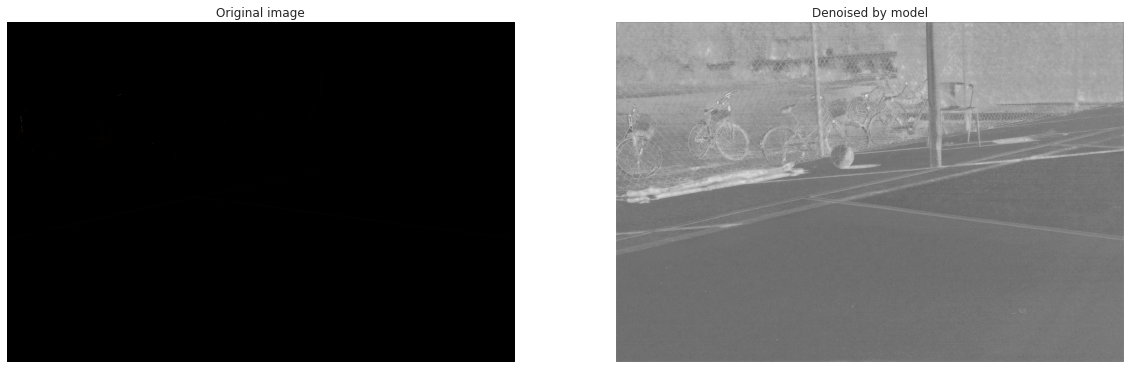

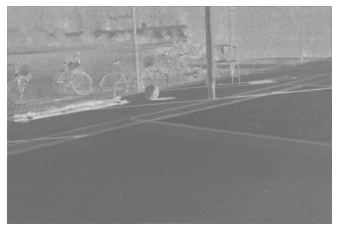

In [25]:

from PIL import Image
AttU_model = AttU_Net()
AttU_model.load_state_dict(torch.load('trained_model/attension_Unet_GAN_best_model.pt',map_location='cuda'))
AttU_model = AttU_model.to(device)
image_name = 'dataset/Sony/short/10006_07_0.1s.ARW'

def display_mask_image(model, image_path, amp_ratio, render=False, file_name = 'pred'):
    model.eval()
        
    orig_image = post_process(rawpy.imread(image_path))
    
    fig=plt.figure(figsize=(20, 10))
    fig.add_subplot(1, 2, 1)
    plt.imshow(orig_image, vmin=0, vmax=1)
    plt.title('Original image')
    plt.axis('off')
    plt.grid(b=None)
    
    image = pack_raw(rawpy.imread(image_path)) * amp_ratio
   
    image = numpy_to_torch(np.clip(image, a_min=0.0, a_max=1.0)).unsqueeze(0)
    image = image.to(device)
    print('->'*10,image.shape)
    with torch.no_grad():
       
        
        activation = {}
        def get_activation(name):
            def hook(model, input, output):
                activation[name] = output.detach()
            return hook
        model.Att2.psi.register_forward_hook(get_activation("psi_output"))
        y_hat = model(image)
        y_hat = activation['psi_output']
        
        print('Y'*10, y_hat.shape)
        y_hat = torch.clamp(y_hat, min=0.0, max=1.0)
    image = y_hat.squeeze().squeeze().cpu().numpy()
        
    fig.add_subplot(1, 2, 2)
    plt.imshow(image,cmap='gray',vmin=0, vmax=1)
    plt.title('Denoised by model')
    plt.axis('off')
    plt.grid(b=None)
    plt.show()
    
    
    
    plt.imshow(image,cmap='gray', vmin=0, vmax=1)
    plt.axis('off')
    plt.plot()
    plt.savefig(f'custom_images/{file_name}.png')
   
    random_array = image * 255
    random_array = random_array.astype(np.uint8)
    random_image = Image.fromarray(random_array)
    random_image.save(f'custom_images/processed_{file_name}.png')

                
    if render:
        scipy.misc.toimage(image * 255, high=255, low=0, cmin=0, cmax=255).save(f'custom_images/processed_{file_name}.png')

    plt.show()
    
    
display_mask_image(AttU_model, image_name, 200, file_name ='attension_Unet_MASK')